# AlexNet

>Winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2012

<div style="text-align:center"><img src="../images/alexnet.svg" title="Source: d2l.ai" style="zoom:50%"></div>

In [ ]:
from fastai2.vision.all import *
from fast_impl.core import arch_summary
from fast_impl.transforms import *

In [ ]:
path = untar_data(URLs.CIFAR)

## Preprocessing
* Global Contrast Normalization
* ZCA Whitening

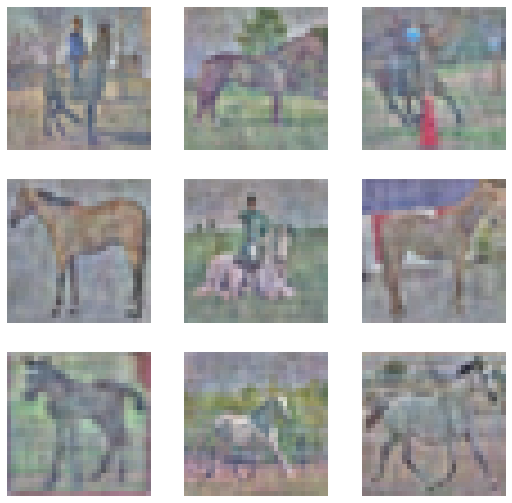

In [ ]:
ds = Datasets(get_image_files(path/'train'),Pipeline([PILImage.create]))
dl4 = TfmdDL(ds,bs=128,after_item=[ToTensor,IntToFloatTensor],
             after_batch=[GlobalContrastNorm,
                          ZCAWhitenWrapper],device='cuda')
dl4.show_batch()

In [ ]:
def get_dataloaders(bs=64,normalize=True,gcn=False,
                    zca_whiten=False,decode_norm=True,
                    verbose=False):
  batch_tfms = [Normalize.from_stats(*cifar_stats)] if normalize else []
  if gcn: batch_tfms.append(GlobalContrastNorm(decode_norm=decode_norm))
  if zca_whiten: batch_tfms.append(ZCAWhitenWrapper(decode_norm=decode_norm))
  dblock = DataBlock((ImageBlock,CategoryBlock),
                    get_items=get_image_files,
                    get_y=parent_label,
                    splitter=GrandparentSplitter(valid_name='test'),
                    batch_tfms=batch_tfms)
  if verbose: dblock.summary(path,bs=bs)
  return dblock.dataloaders(path,bs=bs,device='cuda')

Have tried several combinations of Global Contrast Normalization and ZCA Whitening but nothing helped to improve accuracy. Feel free to tweak the epsilon values of both GCN and ZCA Whitening to achive better results.

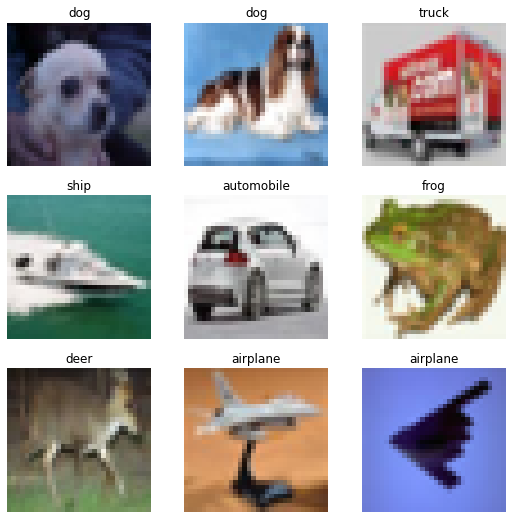

In [ ]:
dls = get_dataloaders(bs=128)
dls.show_batch()

# AlexNet Architecture

The architecture have been tweaked a bit to work with CIFAR images (32x32). I'm using AlexNet-B for kernel sizes 

In [ ]:
class AlexConvBlock(nn.Sequential):
  def __init__(self,ni,nf,ks,stride=1,padding=1,use_lrn=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)]
    if use_lrn: layers.append(nn.LocalResponseNorm(5,k=2.0))
    return super().__init__(*layers)

class ConvReLU(nn.Sequential):
  def __init__(self,ni,nf,ks=3,stride=1,padding=1):
    layers = [nn.Conv2d(ni, nf, 
                        kernel_size=ks,
                        stride=stride,
                        padding=padding),
              nn.ReLU(inplace=True)]
    return super().__init__(*layers)
  
class AlexDense(nn.Sequential):
  def __init__(self,ni,nf,dropout=True):
    layers = []
    if dropout: layers.append(nn.Dropout())
    layers += [nn.Linear(ni,nf),nn.ReLU(inplace=True)]
    super().__init__(*layers)

def alexnet(num_classes=10,use_lrn=True):
  return nn.Sequential(AlexConvBlock(3,64,ks=11,stride=4,padding=5,use_lrn=use_lrn),
                       AlexConvBlock(64,192,ks=5,padding=2,use_lrn=use_lrn),
                       ConvReLU(192,384),
                       ConvReLU(384,256),
                       ConvReLU(256,256),
                       nn.MaxPool2d(2,2),
                       Flatten(),
                       AlexDense(256,512),
                       AlexDense(512,512),
                       nn.Linear(512,num_classes))

In [ ]:
model = alexnet()
# apply_init(model)

In [ ]:
model(torch.randn(128,3,32,32)).shape

torch.Size([128, 10])

In [ ]:
exp_name='alexnet-lrn'
save_model = SaveModelCallback(monitor='error_rate',fname=exp_name)
early_stopping = EarlyStoppingCallback(monitor='valid_loss',patience=20,min_delta=1e-4)
lr_decay = ReduceLROnPlateau(patience=4,min_delta=1e-4)
cbs= [save_model,early_stopping,lr_decay]

# Wandb Setup and Callback

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 0eeec364e78796a87e0471ba38bb3a3675a7bf63
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [ ]:
import wandb
wandb.init(project='network-in-network',name='alexnet-lrn')

W&B Run: https://app.wandb.ai/kshitijpatil09/network-in-network/runs/2kz4dhjt

In [ ]:
from fastai2.callback.wandb import *

# Training

In [ ]:
# sgd = partial(SGD,lr=1e-2,mom=0.9,wd=1e-4)

In [ ]:
arch_summary(model)

[0 ] AlexConvBlock    : 4   layers
[1 ] AlexConvBlock    : 4   layers
[2 ] ConvReLU         : 2   layers
[3 ] ConvReLU         : 2   layers
[4 ] ConvReLU         : 2   layers
[5 ] MaxPool2d        : 1   layers
[6 ] Flatten          : 1   layers
[7 ] AlexDense        : 3   layers
[8 ] AlexDense        : 3   layers
[9 ] Linear           : 1   layers


Splitter is defined in case you want to perform discriminative lr training

In [ ]:
def alex_splitter(o): return L(o[:7],o[7:]).map(params)
learn = Learner(dls,model,opt_func=ranger,cbs=cbs,metrics=error_rate,
                pretrained=False,splitter=alex_splitter)

In [ ]:
learn.summary()

Sequential (Input shape: ['128 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 64 x 8 x 8     23,296     True      
________________________________________________________________
ReLU                 128 x 64 x 8 x 8     0          False     
________________________________________________________________
MaxPool2d            128 x 64 x 4 x 4     0          False     
________________________________________________________________
LocalResponseNorm    128 x 64 x 4 x 4     0          False     
________________________________________________________________
Conv2d               128 x 192 x 4 x 4    307,392    True      
________________________________________________________________
ReLU                 128 x 192 x 4 x 4    0          False     
________________________________________________________________
MaxPool2d            128 x 192 x 2 x 2    0          False     
__________________________________________________

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.009120108559727669)

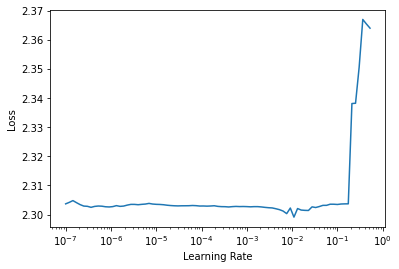

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(50,lr=1e-3,cbs=WandbCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.752079,1.650428,0.627500,00:46
1,1.429019,1.327242,0.493300,00:46
2,1.227642,1.179879,0.424100,00:46
3,1.115560,1.124126,0.396900,00:46
4,1.010167,1.076561,0.378600,00:45
5,0.912004,1.041445,0.354700,00:46
6,0.811738,1.070676,0.353600,00:46
7,0.750284,1.089693,0.350800,00:46
8,0.656150,1.074394,0.340700,00:46
9,0.578632,1.153337,0.339900,00:45


Epoch 9: reducing lr to 0.0001
Epoch 13: reducing lr to 0.0001
Epoch 17: reducing lr to 0.0001
Epoch 21: reducing lr to 0.0001
No improvement since epoch 5: early stopping


In [ ]:
learn.load(exp_name)

In [ ]:
learn.validate()